In [38]:
#pip install torch torchvision torchsummary

In [39]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn

# Step 1: Choose a Pre-trained Model
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model and move it to the appropriate device (GPU or CPU)
model = models.vgg16(pretrained=True).to(device)

print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
# Step 2: Load and modify the model

num_classes = 4
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes).to(device)

def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc

In [41]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final fully connected layer (classifier[6])
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [42]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

transform = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = 'AugmentedAlzheimerDataset'#v2 before this

full_dataset = torchvision.datasets.ImageFolder(root=data_path,
                                 transform=transformation)

train_size = int(0.7 * len(full_dataset))  # 70% data will be trained
test_size = len(full_dataset) - train_size  # 30% data will be tested
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])



# Train Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')



Training dataset size: 23784
Testing dataset size: 10194


In [43]:
# Step 5: Model Training

# Loss & Optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0


Epoch [1/5], Step [100/744], Loss: 1.2167
Epoch [1/5], Step [200/744], Loss: 1.3480
Epoch [1/5], Step [300/744], Loss: 1.2560
Epoch [1/5], Step [400/744], Loss: 1.2658
Epoch [1/5], Step [500/744], Loss: 1.2436
Epoch [1/5], Step [600/744], Loss: 0.8884
Epoch [1/5], Step [700/744], Loss: 1.1065
Epoch [2/5], Step [100/744], Loss: 1.0139
Epoch [2/5], Step [200/744], Loss: 0.9321
Epoch [2/5], Step [300/744], Loss: 0.9754
Epoch [2/5], Step [400/744], Loss: 0.9073
Epoch [2/5], Step [500/744], Loss: 0.8336
Epoch [2/5], Step [600/744], Loss: 0.8760
Epoch [2/5], Step [700/744], Loss: 0.6228
Epoch [3/5], Step [100/744], Loss: 1.0924
Epoch [3/5], Step [200/744], Loss: 0.8452
Epoch [3/5], Step [300/744], Loss: 0.7598
Epoch [3/5], Step [400/744], Loss: 0.6972
Epoch [3/5], Step [500/744], Loss: 0.7657
Epoch [3/5], Step [600/744], Loss: 0.8235
Epoch [3/5], Step [700/744], Loss: 0.9638
Epoch [4/5], Step [100/744], Loss: 0.6583
Epoch [4/5], Step [200/744], Loss: 0.7846
Epoch [4/5], Step [300/744], Loss:

In [44]:
# Set Model to evaluation mode
model.eval

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


70.1196782421032


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[1548   79  359  666]
 [  12 1930    3   11]
 [ 186   39 2087  549]
 [ 312   73  757 1583]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.58      0.66      2652
           1       0.91      0.99      0.95      1956
           2       0.65      0.73      0.69      2861
           3       0.56      0.58      0.57      2725

    accuracy                           0.70     10194
   macro avg       0.72      0.72      0.72     10194
weighted avg       0.70      0.70      0.70     10194



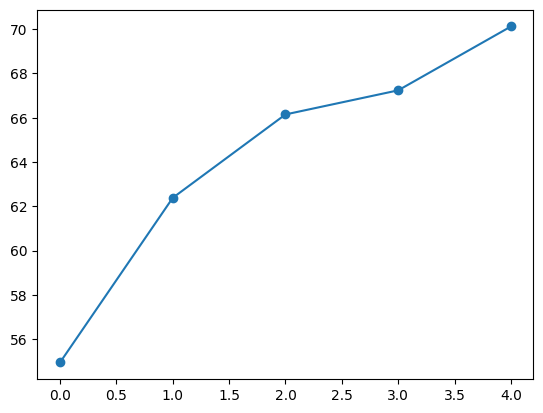

[0, 1, 2, 3, 4] [54.944084755738665, 62.37983127329802, 66.14675299195605, 67.23562880125564, 70.1196782421032]


In [50]:
plt.plot(epoch_nums, training_acc, marker='o')
plt.show()
print(epoch_nums, training_acc)

[1.7226747274398804, 3.1599279642105103, 4.59570038318634, 5.9670491218566895, 7.815006732940674, 9.40464437007904, 10.863651037216187, 12.191766262054443, 13.6782306432724, 15.234884023666382, 16.742132782936096, 18.129047989845276, 19.63737201690674, 20.92044234275818, 22.43370032310486, 23.859070777893066, 25.11675989627838, 26.767637610435486, 28.10164737701416, 29.455291390419006, 30.843952655792236, 32.11396813392639, 33.4462331533432, 34.773964405059814, 36.09161591529846, 37.58003509044647, 38.91087889671326, 40.33502113819122, 41.64892506599426, 42.82170653343201, 44.46530604362488, 45.93231678009033, 47.23485541343689, 48.57426071166992, 49.79124987125397, 51.0939918756485, 52.285239934921265, 53.67420840263367, 55.14490556716919, 56.50169050693512, 57.8039333820343, 59.03271532058716, 60.35833394527435, 61.71099817752838, 62.951120495796204, 64.28147435188293, 65.61572980880737, 66.91514015197754, 68.19228768348694, 69.52676033973694, 70.92536342144012, 72.21223676204681, 73

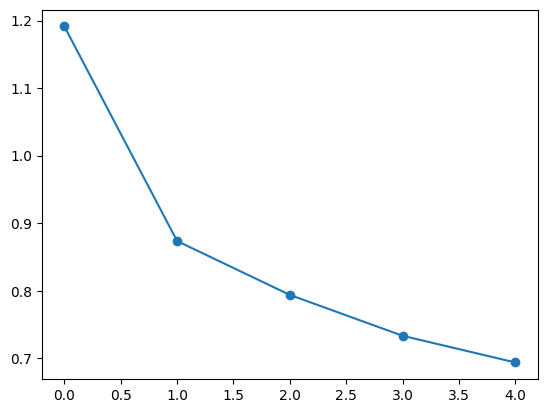

[0, 1, 2, 3, 4] [1.191193744059532, 0.8736235570683274, 0.7938908200751069, 0.7334304776803781, 0.6938790664557488]


In [51]:
print(loss_list)

#plt.plot(loss_list)
plt.plot(training_loss, marker='o')
plt.show()

print(epoch_nums, training_loss)

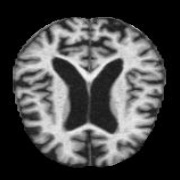

torch.Size([1, 3, 224, 224])
tensor([1], device='cuda:0')
ModerateDemented


In [48]:
model.eval()  # Switch model to evaluation mode

from PIL import Image

# Open the image and convert to RGB
img = Image.open('images/moderate.jpg').convert('RGB')

# Display the image (use .show() instead of display)
display(img)

# Define the transformations
transforms = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

# Compose the transformations
transformations = torchvision.transforms.Compose(transforms)

# Apply the transformations to the image
transformed = transformations(img)

# Add batch dimension (unsqueeze)
transformed = transformed.unsqueeze(0)

# Check the size of the tensor
print(transformed.size())

# Move the transformed image to the same device as the model (GPU or CPU)
transformed = transformed.to(device)

# Pass the transformed image through the model
predicted_output = model(transformed)

# Get the predicted class
_, predicted = torch.max(predicted_output, 1)

# Print the predicted class index
print(predicted)

# Convert the predicted class index to a class name
predicted = predicted.cpu().data.numpy()[0]

# Print the predicted class label
print(classes[predicted])


In [49]:
torch.save(model.state_dict(), "vgg16.pth")